## Factor Analysis

In [1]:
# !pip install factor_analyzer
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt    
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn import preprocessing

import factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('5_FactorAna.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'name', 'city', 'latitude', 'longitude', 'price_level',
       'rating', 'review_count', 'delivery', 'pickup', 'reservation', 'alias',
       'categories', 'coordinates', 'display_phone', 'distance', 'id',
       'image_url', 'is_closed', 'location', 'phone', 'price', 'transactions',
       'url', 'reviews', 'vader', 'vader_positive', 'vader_negative',
       'compound', 'neutral', 'vader_pos_neg', 'NRC', 'NRC_positive',
       'NRC_surprise', 'NRC_anticipation', 'NRC_sadness', 'NRC_negative',
       'NRC_trust', 'NRC_anger', 'NRC_joy', 'NRC_disgust', 'NRC_fear',
       'NRC_pos_neg', 'is_Michelin', 'sims_score', 'Mi_nomi_score',
       'Mi_nomi_score_scale', 'star', 'category', 'French',
       'American (Traditional)', 'Korean', 'Italian', 'Thai', 'American (New)',
       'Chinese', 'Japanese', 'Mediterranean', 'Spanish', 'Mexican', 'Indian',
       'British', 'Seafood', 'Wine Bars', 'Steakhouses', 'Dim Sum', 'City',
       'New York', 'Chicago', 'Washington', 'S

In [200]:
df_fa = df[['NRC_positive','compound', 'neutral', 'NRC_negative','rating', 'review_count',
            'price1', 'price2', 'price3', 'price4','delivery', 'pickup', 'reservation']]  # 18
df_fa = pd.DataFrame(preprocessing.scale(df_fa),columns=df_fa.columns)

In [201]:
fac_num=8
fa = FactorAnalyzer(n_factors=fac_num,rotation='varimax',method='principal', impute='drop' )  #n_factors=10,
fa.fit(df_fa)

fa.get_communalities()  #

total_var = pd.DataFrame(np.matrix(fa.get_factor_variance()).T,columns=['variance','proportion_var_explain','cumulative_var_explain'])
total_var
# variance – The factor variances.
# proportional_variance – The proportional factor variances.
# cumulative_variances 

,variance,proportion_var_explain,cumulative_var_explain
0,2.334273,0.179559,0.179559
1,1.850096,0.142315,0.321875
2,1.625360,0.125028,0.446902
3,1.329798,0.102292,0.549194
4,1.303388,0.100261,0.649455
5,1.132602,0.087123,0.736578
6,1.019008,0.078385,0.814963
7,1.001691,0.077053,0.892017


In [202]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_fa.dropna())
kmo = calculate_kmo(df_fa.dropna())
chi_square_value, p_value
kmo[1]
# Represents the degree to which each observed variable is predicted by the other variables in the dataset.
# In general, a KMO > 0.6 is considered adequate.

0.32463313643749714

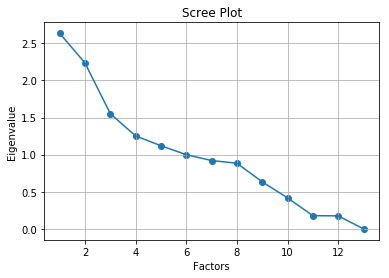

In [203]:
ev, v = fa.get_eigenvalues()  #  eigen values
plt.scatter(range(1,df_fa.shape[1]+1),ev)
plt.plot(range(1,df_fa.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

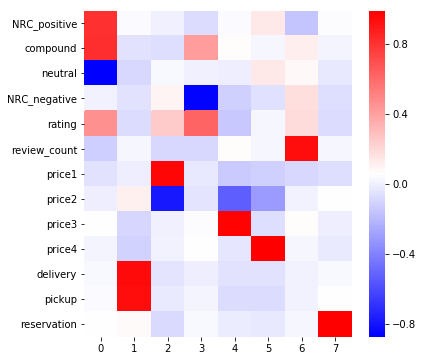

In [204]:
factor_loads = pd.DataFrame(np.matrix(fa.loadings_),index=df_fa.columns) # Factor Loadings Matrix
plt.figure(figsize=(6,6))
sns.heatmap(factor_loads, xticklabels= True, yticklabels= True,cmap="bwr")  
# factor0: positive adj factor, 0: positive review factor, 1: neg fac, 2: polarity pos-neg, 3: Michelin specific, 4: services, 
# 5: nonMi specific, 6: reviews, 7: reservation
 

In [205]:
df_newfa = pd.DataFrame(np.matrix(fa.transform(df_fa.fillna(0))))  # Get the factor scores for new data set

y = df['is_Michelin']
X = sm.add_constant(df_newfa)
model = sm.OLS(y, X).fit()

model.summary()

tvalues = model.tvalues[1:]#/sum(model.tvalues[1:])
# tvalues = model.params[1:]/sum(model.params[1:])

def sort_factors(series, t):
    if t > 0: # positive
        return np.argsort(np.argsort(-series))/sum(np.argsort(-series))
    else: return np.argsort(np.argsort(series))/sum(np.argsort(-series))

for i in range(fac_num):
    df_newfa['factor'+str(i)+'order']= sort_factors(df_newfa.iloc[:,i], tvalues[i])
    
df_newfa['total_order'] = df_newfa.iloc[:,-fac_num:].apply(lambda row: np.dot(row,tvalues),axis=1)

df['FactorAnaScore']=df_newfa['total_order']

In [206]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            is_Michelin   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     405.2
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        21:14:54   Log-Likelihood:                 1467.1
No. Observations:                3809   AIC:                            -2916.
Df Residuals:                    3800   BIC:                            -2860.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0530      0.003     19.859      0.000       0.048       0.058
0              0.0035      0.003      1.308      0.191      -0.002       0.009
1             -0.0270      0.003    -10.108      0.000      -0.032      -0.022
2             -0.0012      0.003     -0.436      0.663      -0.006       0.004
3              0.0070      0.003      2.618      0.009       0.002       0.012
4              0.0313      0.003     11.717      0.000       0.026       0.037
5              0.1458      0.003     54.580      0.000       0.141       0.151
6              0.0080      0.003      2.984      0.003       0.003       0.013
7             -0.0065      0.003     -2.420      0.016      -0.012      -0.001
==============================================================================
Omnibus:                     2235.753   Durbin-Watson:                   1.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63143.628
Skew:                           2.279   Prob(JB):                         0.00
Kurtosis:                      22.419   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [207]:
def get_potentials(df,top=10):
    potent=[]
    for i in df.index:
        potent.append([df['FactorAnaScore'][i],df['name'][i]])
    potential_list = sorted(potent)[:top]
    return potential_list

pre_list = get_potentials(df,top=202)
wall = pre_list[-1][0]

df['reco'] = np.where(df['FactorAnaScore']<wall,1,0)

Precision:			0.31 identified as Michelin are Michelin
Recall/TPR:			0.31 proportion of Michelin identified
False Positive Rate:		0.04 proportion of Non-Michelin identified as Michelin
f-score:			0.31 tradeoff between precision and recall
Accuracy:			0.93 how well the model has classified


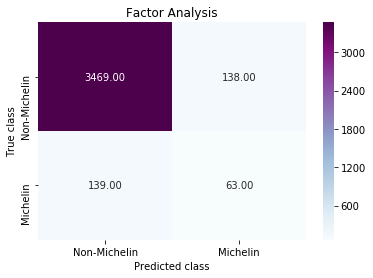

In [208]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
fa_cm = metrics.confusion_matrix(df['is_Michelin'], df['reco'])
sns.heatmap(fa_cm, annot=True, cmap = "BuPu", fmt='.2f',xticklabels = ["Non-Michelin", "Michelin"] , yticklabels = ["Non-Michelin", "Michelin"] )
import matplotlib.pyplot as plt
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Factor Analysis')
plt.savefig('factor_ana_cm')

def c_m_analysis(y_test,logreg_y_pred,fa_cm):
    tn, fp, fn, tp = fa_cm.ravel()
    tpr = tp/(tp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*tpr/(precision+tpr)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("Precision:\t\t\t%1.2f identified as Michelin are Michelin"%(precision))
    print("Recall/TPR:\t\t\t%1.2f proportion of Michelin identified"%(recall))
    print("False Positive Rate:\t\t%1.2f proportion of Non-Michelin identified as Michelin"%fpr)
    print("f-score:\t\t\t%1.2f tradeoff between precision and recall"%(f_score))
    print("Accuracy:\t\t\t%1.2f how well the model has classified"%(accuracy))

c_m_analysis(df['is_Michelin'],df['reco'],fa_cm)

In [43]:
pd.DataFrame(pre_sf)

,0,1
0,-0.002845,Krispy Krunchy Chicken
1,-0.002161,Little Gem Belgian Waffles
2,-0.002035,Lola's Chicken Shack
3,-0.002016,AZIT
4,-0.001998,Spices 3
5,-0.001742,Chez Panisse
6,-0.001739,Sweet Fingers
7,-0.001288,Siam Bay Authentic Thai Cuisine
8,-0.001058,Roll & Bowl
9,-0.000967,Juanita & Maude


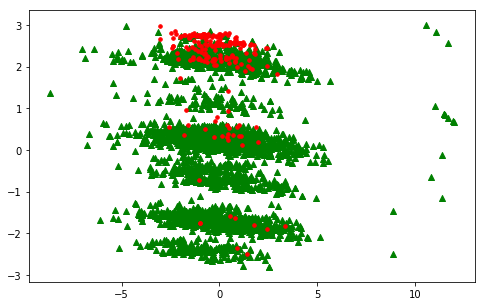

In [269]:
y = df['is_Michelin']
x = df_pca

pca=PCA(n_components=5)
reduced_x=pca.fit_transform(x)

mi_x,mi_y = [],[]
nonmi_x,nonmi_y = [],[]
for i in range(len(reduced_x)):
    if y[i] ==1:
        mi_x.append(reduced_x[i][0])
        mi_y.append(reduced_x[i][1])
    else:
        nonmi_x.append(reduced_x[i][0])
        nonmi_y.append(reduced_x[i][1])

plt.figure(figsize=(8,5))
plt.scatter(mi_x,mi_y,c='r',marker='.',s=50,zorder=2)
plt.scatter(nonmi_x,nonmi_y,c='g',marker='^')
# plt.ylim(-10,10) # plt.xlim(-10,10)
plt.show()

#### The result didn't show significant distinction between the two kinds of restaurants, so we didn't go deeper into this method.

Precision:			0.7443 identified as Michelin are Michelin
Recall/TPR:			0.7441 proportion of Michelin identified
False Positive Rate:		0.2556 proportion of Non-Michelin identified as Michelin
f-score:			0.7442 tradeoff between precision and recall
Accuracy:			0.7442 how well the model has classified


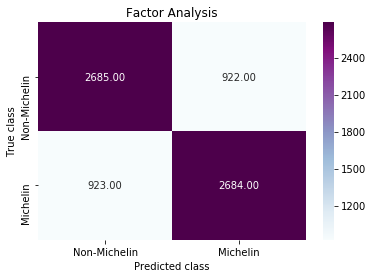

In [199]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
fa_smote_cm = metrics.confusion_matrix(y_resampled, pre_list)
sns.heatmap(fa_smote_cm, annot=True, cmap = "BuPu", fmt='.2f',xticklabels = ["Non-Michelin", "Michelin"] , yticklabels = ["Non-Michelin", "Michelin"] )
import matplotlib.pyplot as plt
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Factor Analysis')
plt.savefig('factor_ana_cm')

def c_m_analysis(y_test,logreg_y_pred,fa_cm):
    tn, fp, fn, tp = fa_cm.ravel()
    tpr = tp/(tp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*tpr/(precision+tpr)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print("Precision:\t\t\t%1.4f identified as Michelin are Michelin"%(precision))
    print("Recall/TPR:\t\t\t%1.4f proportion of Michelin identified"%(recall))
    print("False Positive Rate:\t\t%1.4f proportion of Non-Michelin identified as Michelin"%fpr)
    print("f-score:\t\t\t%1.4f tradeoff between precision and recall"%(f_score))
    print("Accuracy:\t\t\t%1.4f how well the model has classified"%(accuracy))

c_m_analysis(y_resampled, pre_list,fa_smote_cm)